# LA County Board of Supervisors - 2nd District Data Analysis

These maps visualize campaign donations made this campaign cycle to the three candidates running to replace Mark Ridley-Thomas on the Board of Supervisors, L.A. County's governing body. 

In [609]:
"""
A Los Angeles Times theme for Altair.
"""
# Color schemes and defaults
palette = dict(
    black='#000000',
    white='#ffffff',
    default='#82c6df',
    accent='#006d8f',
    highlight='#ec8431',
    democrat='#5789b8',
    republican='#d94f54',
    schemes={
      'category-6': [
        '#3580b1',
        '#ec8431',
        '#ab7fb4',
        '#c89d29',
        '#adc839',
        '#829eb1',
      ],
      'fire-7': [
        '#fbf2c7',
        '#f9e39c',
        '#f8d36e',
        '#f4bb6a',
        '#e68a4f',
        '#d15a40',
        '#ab4232',
      ],
      'fireandice-6': [
        '#e68a4f',
        '#f4bb6a',
        '#f9e39c',
        '#dadfe2',
        '#a6b7c6',
        '#849eae',
      ],
      'ice-7': [
        '#edefee',
        '#dadfe2',
        '#c4ccd2',
        '#a6b7c6',
        '#849eae',
        '#607785',
        '#47525d',
      ],
    }
)


def stiles():
    """
    A Los Angeles Times theme for Altair.
    """
    # Headline stuff
    headlineFontSize = 22
    headlineFontWeight = "normal"
    headlineFont = 'Benton Gothic Bold, sans'

    # Titles for axes and legends and such
    titleFont = 'Benton Gothic Bold, sans'
    titleFontWeight = 'normal'
    titleFontSize = 14

    # Labels for ticks and legend entries and such
    labelFont = 'Benton Gothic, sans'
    labelFontSize = 12
    labelFontWeight = 'bold'

    return dict(
        config=dict(
            view=dict(
                width=800,
                height=450
            ),
            background=palette['white'],
            title=dict(
                anchor='start',
                font=headlineFont,
                fontColor=palette['black'],
                fontSize=headlineFontSize,
                fontWeight=headlineFontWeight,
                Y=-5
            ),
            arc=dict(fill=palette['default']),
            area=dict(fill=palette['default']),
            line=dict(stroke=palette['default'], strokeWidth=3),
            path=dict(stroke=palette['default']),
            rect=dict(fill=palette['default']),
            shape=dict(stroke=palette['default']),
            bar=dict(fill=palette['default']),
            point=dict(stroke=palette['default']),
            symbol=dict(fill=palette['default'], size=30),
            axis=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                titleFontWeight=titleFontWeight,
                labelFont=labelFont,
                labelFontSize=labelFontSize,
                labelFontWeight=labelFontWeight
            ),
            axisX=dict(
                labelAngle=0,
                labelPadding=4,
                tickSize=3
            ),
            axisY=dict(
                labelBaseline='middle',
                maxExtent=45,
                minExtent=45,
                tickSize=2,
                titleAlign='left',
                titleAngle=0,
                titleX=-45,
                titleY=-5
            ),
            legend=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                symbolType='square',
                labelFont=labelFont,
                labelFontSize=labelFontSize + 1,
                labelFontWeight = 'bold'
            ),
            range=dict(
                category=palette['schemes']['category-6'],
                diverging=palette['schemes']['fireandice-6'],
                heatmap=palette['schemes']['fire-7'],
                ordinal=palette['schemes']['fire-7'],
                ramp=palette['schemes']['fire-7']
            )
        )
    )

In [610]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas 
import descartes
import geojson
import scheme
import mapclassify
import json
import pysal as ps
import jenkspy
import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
# alt.themes.register('latimes', lat.theme)
# alt.themes.enable('latimes')

# register the custom theme under a chosen name
alt.themes.register('stiles', stiles)
# enable the newly registered theme
alt.themes.enable('stiles')


ThemeRegistry.enable('stiles')

### Get the data from our larger donations database of committees in all countywide races back to 2007. 

In [611]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [612]:
alldonations =  psql.read_sql("SELECT * FROM contributions", database_con)

### Let's clean up the spaces and capitalization in field names

In [613]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [614]:
alldonations.head(2)

last_name first_name committee_id                      committee_name  \
0    Barger    Kathryn      1414462  Kathryn Barger for Supervisor 2020   
1    Barger    Kathryn      1414462  Kathryn Barger for Supervisor 2020   

  office_type district_number schedule   type        date  amount_rcvd  ...  \
0         CSU             C05        A  Other  2018-12-31       1500.0  ...   
1         CSU             C05        A  Other  2018-12-31       1500.0  ...   

   employer int_name int_city int_state int_zip_code int_occupation  \
0                                                                     
1                                                                     

  int_employer doc_id rec_id       x  
0                       2557  164858  
1                       2557  164916  

[2 rows x 31 columns]

### Some date parsing

In [615]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [616]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = pd.to_datetime(alldonations['date']).map(lambda dt: dt.replace(day=1))
alldonations['candidate'] = alldonations['first_name'] + ' ' + alldonations['last_name']
alldonations['candidate'] = alldonations['candidate'].str.title()
alldonations['candidate'] = alldonations['candidate'].str.replace("Holly J. Mitchell", "Holly Mitchell")
alldonations['type'] = alldonations['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
alldonations['last_name'] = alldonations['last_name'].str.upper()
alldonations['committee_name'] = alldonations['committee_name'].str.upper()
alldonations['first_name'] = alldonations['first_name'].str.upper()
alldonations['months'] = alldonations['date'].dt.strftime('%m/%Y').astype(str)


In [617]:
alldonations

last_name first_name committee_id  \
0        BARGER    KATHRYN      1414462   
1        BARGER    KATHRYN      1414462   
2      NAJARIAN  ARA JAMES      1376291   
3         LACEY  JACQUELYN      1334856   
4        WESSON       HERB      1414475   
...         ...        ...          ...   
77427    COOLEY      STEVE      1293554   
77428    COOLEY      STEVE      1293554   
77429    COOLEY      STEVE      1293554   
77430    COOLEY      STEVE      1293554   
77431  MITCHELL   HOLLY J.      1415889   

                                        committee_name office_type  \
0                   KATHRYN BARGER FOR SUPERVISOR 2020         CSU   
1                   KATHRYN BARGER FOR SUPERVISOR 2020         CSU   
2      NAJARIAN FOR LOS ANGELES COUNTY SUPERVISOR 2016         CSU   
3          COMMITTEE TO ELECT JACKIE LACEY FOR DA 2012         DAT   
4                           WESSON FOR SUPERVISOR 2020         CSU   
...                                                ...         ...   
77427          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77428          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77429          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77430          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77431     HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020         CSU   

      district_number schedule   type       date  amount_rcvd  ...  \
0                 C05        A  Other 2018-12-31         1500  ...   
1                 C05        A  Other 2018-12-31         1500  ...   
2                 C05        A  Other 2016-04-22         1500  ...   
3                 N/A        A  Other 2012-10-04         1000  ...   
4                 C02        A  Other 2019-04-29         1500  ...   
...               ...      ...    ...        ...          ...  ...   
77427             Cna        A  Other 2007-02-23         1000  ...   
77428             Cna        A  Other 2007-02-21         1000  ...   
77429             Cna        A  Other 2007-02-19          750  ...   
77430             Cna        A  Other 2007-02-16         1000  ...   
77431             C02        A  Other 2019-02-28          750  ...   

       int_occupation int_employer doc_id rec_id       x  year month  \
0                                           2557  164858  2018    12   
1                                           2557  164916  2018    12   
2                                           2302  154849  2016     4   
3                                           1630   88438  2012    10   
4                                           2581  167892  2019     4   
...               ...          ...    ...    ...     ...   ...   ...   
77427                                         33    3971  2007     2   
77428                                         33    3738  2007     2   
77429                                         33    3997  2007     2   
77430                                         33    3807  2007     2   
77431                                       2578  165850  2019     2   

       monthyear           candidate   months  
0     2018-12-01      Kathryn Barger  12/2018  
1     2018-12-01      Kathryn Barger  12/2018  
2     2016-04-01  Ara James Najarian  04/2016  
3     2012-10-01     Jacquelyn Lacey  10/2012  
4     2019-04-01         Herb Wesson  04/2019  
...          ...                 ...      ...  
77427 2007-02-01        Steve Cooley  02/2007  
77428 2007-02-01        Steve Cooley  02/2007  
77429 2007-02-01        Steve Cooley  02/2007  
77430 2007-02-01        Steve Cooley  02/2007  
77431 2019-02-01      Holly Mitchell  02/2019  

[77432 rows x 36 columns]

### Filter out older contributions.

In [618]:
nudonations = alldonations[alldonations.date > '2018-06-30']

### Aggregate by month/year to make sure we filter appropriately. 

In [619]:
nudonations[['date', 'amount_rcvd']].groupby(nudonations.date.dt.to_period("M")).agg(['sum', 'size', 'mean'])

amount_rcvd                   
                sum  size         mean
date                                  
2018-07       87659   150   584.393333
2018-08      232188   323   718.848297
2018-09      304368   473   643.484144
2018-10      609077   803   758.501868
2018-11      176696   207   853.603865
2018-12      859396   700  1227.708571
2019-01      179180   187   958.181818
2019-02      607890   697   872.152080
2019-03      479805   509   942.642436
2019-04      419783   563   745.618117
2019-05      545495   706   772.655807
2019-06     1003559  1398   717.853362

## Three stories: Group 2020 contributions data by 1) race, 2) time, 3) zip code.

### Select only donations to candidates running in District 2

In [620]:
thiscycle = nudonations[(nudonations['date'] > '2018-06-30')]
district_two_candidates = (['PERRY','WESSON','MITCHELL','JEONG'])
thiscycle = thiscycle[thiscycle['last_name'].isin(district_two_candidates)]

In [654]:
thiscycle.groupby('candidate').agg(['sum', 'size', 'mean'])

amount_rcvd                   amount_pd          
                       sum size         mean       sum size mean
candidate                                                       
Chan Jeong           46100   82   562.195122       0.0   82  0.0
Herb Wesson        1119445  960  1166.088542       0.0  960  0.0
Holly Mitchell      564594  767   736.106910       0.0  767  0.0
Jan Perry           509760  893   570.839866       0.0  893  0.0

In [655]:
thiscycle.head(3)

last_name first_name committee_id              committee_name office_type  \
4     WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
71    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
72    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

   district_number schedule       type       date  amount_rcvd  ...  \
4              C02        A      Other 2019-04-29         1500  ...   
71             N/A        A  Committee 2018-12-31         1500  ...   
72             N/A        A  Committee 2018-12-31         1500  ...   

    int_occupation int_employer doc_id rec_id       x  year month  monthyear  \
4                                        2581  167892  2019     4 2019-04-01   
71                                       2546  164456  2018    12 2018-12-01   
72                                       2546  164634  2018    12 2018-12-01   

      candidate   months  
4   Herb Wesson  04/2019  
71  Herb Wesson  12/2018  
72  Herb Wesson  12/2018  

[3 rows x 36 columns]

In [656]:
thiscycletrim = thiscycle[[
    'last_name',
    'first_name',
    'candidate',
    'committee_id',
    'committee_name',
    'office_type',
    'district_number',
    'schedule',
    'type',
    'date',
    'amount_rcvd',
    'description',
    'contributor_first_name',
    'contributor_last_name',
    'contributor_address',
    'contributor_city',
    'contributor_state',
    'contributor_zip_code',
    'occupation',
    'employer',
    'doc_id',
    'rec_id',
    'year',
    'month',
    'months'
]]

# EXPORT FOR 'THISCYCLE' TABLE

In [657]:
thiscycletrim.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycle.csv", index=False)

***

### 1) Create a dataframe with summary stats for each campaign this cycle

In [658]:
thiscycletotals = thiscycle.groupby(['candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

### 1) Clean up the hierarchical column structure. Standardize names in all caps.

In [659]:
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].astype(int)
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round()
thiscycletotals

candidate  amount_rcvdsize  amount_rcvdmean  amount_rcvdsum
0      Chan Jeong               82              562           46100
1     Herb Wesson              960             1166         1119445
2  Holly Mitchell              767              736          564594
3       Jan Perry              893              570          509760

# EXPORT FOR 'THISCYCLETOTALS' TABLE

In [660]:
thiscycletotals.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycletotals.csv", index=False)

***

## 2) When were the donations given during the time period?

In [661]:
thiscycletime = thiscycle.groupby(['monthyear','year','month', 'candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [662]:
thiscycletime
flat_columns = [''.join(t) for t in thiscycletime.columns]
thiscycletime.columns = flat_columns
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].astype(int)
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].round()
thiscycletime.head(10)
thiscycletime['months'] = thiscycletime['monthyear'].dt.strftime('%m/%d/%Y').astype(str)
thiscycletime

monthyear  year month       candidate  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12     Herb Wesson              357             1275   
1  2019-01-01  2019     1     Herb Wesson               78             1048   
2  2019-01-01  2019     1       Jan Perry               59              642   
3  2019-02-01  2019     2     Herb Wesson               36             1031   
4  2019-02-01  2019     2  Holly Mitchell              477              837   
5  2019-02-01  2019     2       Jan Perry               94              839   
6  2019-03-01  2019     3     Herb Wesson              143             1192   
7  2019-03-01  2019     3  Holly Mitchell               19              546   
8  2019-03-01  2019     3       Jan Perry              112              670   
9  2019-04-01  2019     4     Herb Wesson               99             1096   
10 2019-04-01  2019     4  Holly Mitchell               83              527   
11 2019-04-01  2019     4       Jan Perry              126              534   
12 2019-05-01  2019     5      Chan Jeong               77              585   
13 2019-05-01  2019     5     Herb Wesson               95             1056   
14 2019-05-01  2019     5  Holly Mitchell               45              575   
15 2019-05-01  2019     5       Jan Perry               93              556   
16 2019-06-01  2019     6      Chan Jeong                5              200   
17 2019-06-01  2019     6     Herb Wesson              152             1090   
18 2019-06-01  2019     6  Holly Mitchell              143              593   
19 2019-06-01  2019     6       Jan Perry              409              485   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            81800  01/01/2019  
2            37930  01/01/2019  
3            37150  02/01/2019  
4           399665  02/01/2019  
5            78875  02/01/2019  
6           170550  03/01/2019  
7            10375  03/01/2019  
8            75150  03/01/2019  
9           108596  04/01/2019  
10           43800  04/01/2019  
11           67325  04/01/2019  
12           45100  05/01/2019  
13          100325  05/01/2019  
14           25895  05/01/2019  
15           51725  05/01/2019  
16            1000  06/01/2019  
17          165725  06/01/2019  
18           84859  06/01/2019  
19          198755  06/01/2019

## Let's make some charts
### Totals donations collected by 2020 supervisor candidates since last summer

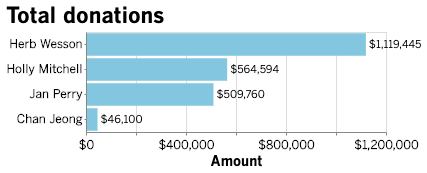

In [668]:

bars = alt.Chart(thiscycletotals, title="Total donations").mark_bar().encode(
    x=alt.X('amount_rcvdsum:Q',title="Amount",axis=alt.Axis(format='$,S', tickCount=4)),
    y=alt.Y(
        'candidate:N',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdsum",  
            op="sum",  
            order="descending",  
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  
).encode(
    text=alt.Text('amount_rcvdsum:Q', format="$,")
)
    
(bars + text).properties(height=100, width=300)

### What's the average donation size? 

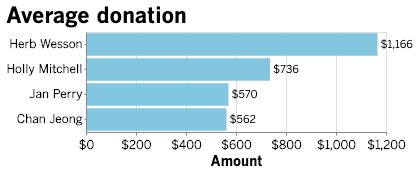

In [669]:
bars = alt.Chart(thiscycletotals, title="Average donation").mark_bar().encode(
    x=alt.X('amount_rcvdmean:Q',title="Amount",axis=alt.Axis(format='$,S', tickCount=4)),
    y=alt.Y(
        'candidate:N',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdmean",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdmean:Q', format="$,")
)

(bars + text).properties(height=100, width=300)

### How many donations have the candidates received? 

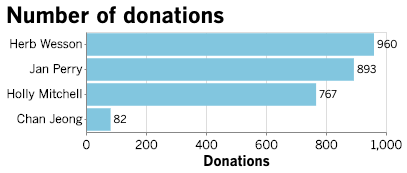

In [670]:
bars = alt.Chart(thiscycletotals, title="Number of donations").mark_bar().encode(
    x=alt.X('amount_rcvdsize:Q',title="Donations",axis=alt.Axis(format=',S', tickCount=6)),
    y=alt.Y(
        'candidate:N',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsize:Q', format=",")
)
    
(bars + text).properties(height=100, width=300)

### Sum of donations by month

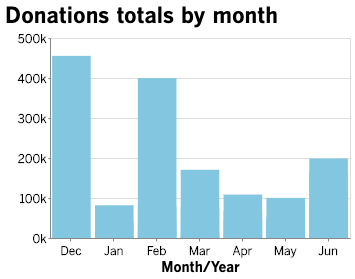

In [671]:
bars = alt.Chart(thiscycletime, title="Donations totals by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="",
        axis=alt.Axis(format="1s")
        )
    )

(bars).properties(height=200, width=300) 

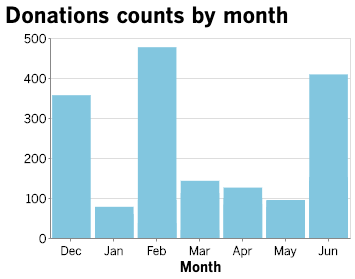

In [672]:
bars = alt.Chart(thiscycletime, title="Donations counts by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsize:Q',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",
            op="sum", 
            order="descending",  
        )
    )
)

(bars).properties(height=200, width=300)

In [673]:
thiscycletime

monthyear  year month       candidate  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12     Herb Wesson              357             1275   
1  2019-01-01  2019     1     Herb Wesson               78             1048   
2  2019-01-01  2019     1       Jan Perry               59              642   
3  2019-02-01  2019     2     Herb Wesson               36             1031   
4  2019-02-01  2019     2  Holly Mitchell              477              837   
5  2019-02-01  2019     2       Jan Perry               94              839   
6  2019-03-01  2019     3     Herb Wesson              143             1192   
7  2019-03-01  2019     3  Holly Mitchell               19              546   
8  2019-03-01  2019     3       Jan Perry              112              670   
9  2019-04-01  2019     4     Herb Wesson               99             1096   
10 2019-04-01  2019     4  Holly Mitchell               83              527   
11 2019-04-01  2019     4       Jan Perry              126              534   
12 2019-05-01  2019     5      Chan Jeong               77              585   
13 2019-05-01  2019     5     Herb Wesson               95             1056   
14 2019-05-01  2019     5  Holly Mitchell               45              575   
15 2019-05-01  2019     5       Jan Perry               93              556   
16 2019-06-01  2019     6      Chan Jeong                5              200   
17 2019-06-01  2019     6     Herb Wesson              152             1090   
18 2019-06-01  2019     6  Holly Mitchell              143              593   
19 2019-06-01  2019     6       Jan Perry              409              485   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            81800  01/01/2019  
2            37930  01/01/2019  
3            37150  02/01/2019  
4           399665  02/01/2019  
5            78875  02/01/2019  
6           170550  03/01/2019  
7            10375  03/01/2019  
8            75150  03/01/2019  
9           108596  04/01/2019  
10           43800  04/01/2019  
11           67325  04/01/2019  
12           45100  05/01/2019  
13          100325  05/01/2019  
14           25895  05/01/2019  
15           51725  05/01/2019  
16            1000  06/01/2019  
17          165725  06/01/2019  
18           84859  06/01/2019  
19          198755  06/01/2019

***

# Which types of donors gave to the candidates? 

In [674]:
thiscycle.groupby(['type','candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

type       candidate amount_rcvd                     
                                                 size         mean     sum
0               Committee     Herb Wesson          39  1365.384615   53250
1               Committee  Holly Mitchell         138  1127.840580  155642
2               Committee       Jan Perry           3   750.000000    2250
3              Individual      Chan Jeong          64   537.500000   34400
4              Individual     Herb Wesson         617  1136.377634  701145
5              Individual  Holly Mitchell         447   465.102908  207901
6              Individual       Jan Perry         794   545.415617  433060
7                   Other      Chan Jeong          18   650.000000   11700
8                   Other     Herb Wesson         289  1194.636678  345250
9                   Other  Holly Mitchell         163  1067.797546  174051
10                  Other       Jan Perry          96   775.520833   74450
11  Small Donor Committee     Herb Wesson          15  1320.000000   19800
12  Small Donor Committee  Holly Mitchell          19  1421.052632   27000

## Share of the candidates' donations by type

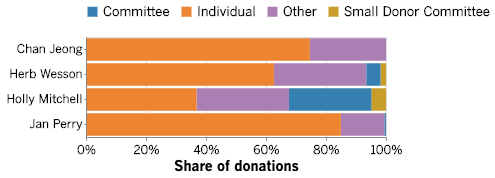

In [675]:
bars = alt.Chart(thiscycle, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
)


(bars).properties(height=100, width=300)

## Which zip codes are in LA County?

### Read in a list extracted from a spatial file

In [676]:
la_zipcodes = pd.read_csv('/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/lazips_grouped.csv')

In [677]:
la_zips_list = la_zipcodes['zip_code'].to_csv(header=False, index=False).strip('\n').split('\n')

In [678]:
thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]
thiscycle_la_zips = thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]

In [679]:
thiscycletrim['lacounty'] = np.where(thiscycletrim['contributor_zip_code'].isin(la_zips_list), 'Inside LA County', 'Outside LA County')

/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Now, what share of each candidates' donations are from LA County?

### Share of donations from inside and outside the county

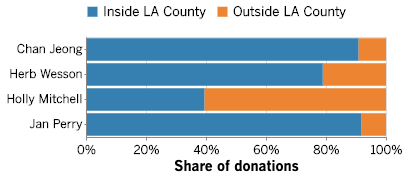

In [680]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations", axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('lacounty',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('lacounty', sort='ascending')
)


(bars).properties(height=100, width=300)

### Total amount of donations — by location

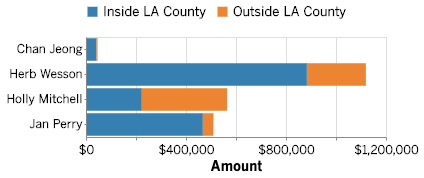

In [681]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', title="Amount", axis=alt.Axis(format='$,S', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('lacounty',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('lacounty', sort='ascending')
)


(bars).properties(height=100, width=300)

### Total amount of donations — by donor type

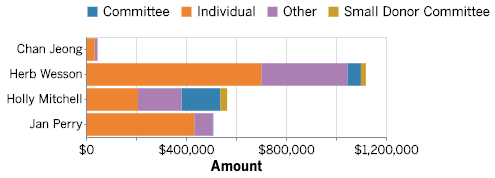

In [682]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', title="Amount",axis=alt.Axis(format='$,S', tickCount=4)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
)

(bars).properties(height=100, width=300)

***

## Which zip codes are most common?

### Filter for zip codes inside and outside the county

In [683]:
in_la = thiscycletrim[thiscycletrim.lacounty.isin(['Inside LA County'])]
out_la = thiscycletrim[thiscycletrim.lacounty.isin(['Outside LA County'])]

### Donation TOTALS for zips inside and outside the county, by zip

In [684]:
#zip sum totals w/o candidates — in LA
sum_inla_zips = in_la.groupby(['contributor_zip_code'])['amount_rcvd'].agg('sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/o candidates — outside LA
sum_outla_zips = out_la.groupby(["contributor_zip_code"])['amount_rcvd'].agg( 'sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/ candidates — in LA
cand_sum_inla_zips = in_la.groupby(['contributor_zip_code', 'candidate'])['amount_rcvd'].agg('sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/ candidates — out LA
cand_sum_outla_zips = out_la.groupby(["contributor_zip_code",'candidate'])['amount_rcvd'].agg( 'sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

### Donation COUNTS for zips inside and outside the county, by zip

In [685]:
#zip counts w/o candidates — in LA
size_inla_zips = in_la.groupby(['contributor_zip_code']).agg('size').to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/o candidates — out LA
size_outla_zips = out_la.groupby(['contributor_zip_code']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/ candidates — in LA
cand_size_inla_zips = in_la.groupby(['contributor_zip_code', 'candidate']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/ candidates — out LA
cand_size_outla_zips = out_la.groupby(['contributor_zip_code', 'candidate']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

In [686]:
cand_size_inla_zips.head(10)

contributor_zip_code       candidate  size
16                 90008       Jan Perry    31
18                 90010     Herb Wesson    29
128                90056       Jan Perry    27
127                90056  Holly Mitchell    25
35                 90015       Jan Perry    25
171                90210       Jan Perry    25
26                 90012       Jan Perry    24
109                90043  Holly Mitchell    23
125                90049       Jan Perry    20
208                90266     Herb Wesson    19

### Which 10 LA zip codes gave the most? 

In [689]:
sum_inla_zips.head(10)

amount_rcvd
contributor_zip_code             
90010                       54400
90210                       45680
90049                       41499
90017                       41150
90020                       35900
90024                       33500
90015                       31975
90019                       31850
90056                       27775
90025                       27510

### Which 10 outside LA zip codes gave the most? 

In [690]:
sum_outla_zips.head(10)

amount_rcvd
contributor_zip_code             
95814                       91300
95815                       12250
92660                        8450
94105                        7500
95816                        7200
92649                        7000
95811                        6750
20001                        6750
60611                        6000
94901                        5500